In [1]:
# class to do multivariant fitting with polynomials
# you can have different degree polynomials
# in different dimensions

In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
matplotlib.rcParams.update({'font.size': 16}) 

import numpy as np

In [270]:
def generate_degrees(maxdegs, max_deg_total=None):
    """
    generates an array of monomial exponents (or degrees)
    that can be used to generate a design matrix to perform
    linear basis polynomial regression
    
    intput:
        maxdegs: list of len number of dimensions
            list of max deg in each dimension
        max_deg_total: int (default: None)
            max degree of a term.
            If None then will use the maximum of `maxdegs`.
        
    returns:
        numpy.ndarray of shape (M, dim)
        M = total number of terms
        dim = dimension
    """
    if max_deg_total == None:
        max_deg_total = np.max(maxdegs)

    # create lists of degrees for each dimension
    xsdims = [range(deg+1) for deg in maxdegs]
    # tensor product them
    xs = np.meshgrid(*xsdims)
    # ravel them into a list into a 1D array
    xs = list(map(np.ravel, xs))
    # degrees is an np.ndarray of shape (M, dim)
    degrees = np.array(list(zip(*xs)))
    # restrict the max degree of each term to be less than max_deg_total+1
    mask_total_deg = np.sum(degrees,axis=-1) < max_deg_total + 1
    # restrict the max degree of each dimension
    mask_degs = [degrees[:,i] < maxdegs[i] + 1 for i in range(len(maxdegs))]
    # make a mega mask of all masks
    mask = np.prod(np.row_stack((mask_total_deg, *mask_degs)), axis=0, dtype=bool)
    return np.array(degrees[mask])

In [271]:
degrees = generate_degrees([2,2])

In [272]:
degrees.shape

(6, 2)

In [273]:
degrees

array([[0, 0],
       [1, 0],
       [2, 0],
       [0, 1],
       [1, 1],
       [0, 2]])

In [274]:
degrees

array([[0, 0],
       [1, 0],
       [2, 0],
       [0, 1],
       [1, 1],
       [0, 2]])

In [340]:
class LinearPolynomialBasisRegression(object):
    def __init__(self):
        pass
    
    def make_degrees(self, maxdegs, max_deg_total):
        return generate_degrees(maxdegs, max_deg_total)
    
    def fit(self, X, y, method, maxdegs, max_deg_total):
        """
        input:
            X: np.ndarray. shape (N, ndim)
            y: np.ndarray. shape (N, 1)
            method:
                'direct': np.linalg.pinv. moore-penrose pseudo inverse
                'least-squres': np.linalg.lstsq. lapack least squares algorithm        
        
        assigns the self.w_ml attribute.
        These are the maximum likelihood coefficients or weights.
        
        """
        N, ndim = X.shape
        
        self.degrees = generate_degrees(maxdegs, max_deg_total).tolist()
        
        Phi = self.make_design_matrix(X, self.degrees)
        
        if method == 'direct':
            self.w_ml = np.dot(np.linalg.pinv(Phi), y)
        elif method == 'least-squres':
            self.w_ml = np.linalg.lstsq(Phi, y, rcond=-1)[0]
        
    def make_design_matrix(self, X, degrees):
        Phi = np.stack([np.prod(X**d, axis=1) for d in degrees], axis=-1)
        return Phi
    
    def predict(self, X):
        
        Phi = self.make_design_matrix(X, self.degrees)
        return np.dot(Phi, self.w_ml)
    
    def loss(self, X, y, method='sum-of-squares'):
        """
        method:
            'sum-of-squres':
            'RMSE': 
            'MSE': 
        """
        
        yhat = self.predict(X)
        
        def mse(y, yhat):
            """
            mean-squared-error function
            """
            errors = (y - yhat)
            loss = np.sum(errors**2, axis=0) / len(y)
            return loss
            
        if method == 'sum-of-squares':
            errors = (y - yhat)
            loss = np.sum(errors**2, axis=0) / 2.0
        elif method == 'MSE':
            loss = mse(y, yhat)
        elif method == 'RMSE':
            loss = np.sqrt(mse(y, yhat))
        else:
            raise ValueError(f"method = {method} not valid.")
            
        return loss

# 1D example

In [341]:
x = np.linspace(-1, 1, 50)

# tw0 = 1
# tw1 = -1
# tw2 = 1
# y = tw0*x**0 + tw1*x**1 + tw2*x**2

# this is the same as the above
tw = np.array([12, -14, 13])
n_coeffs = len(tw)
y = [tw[i]*x**i for i in range(n_coeffs)]
y = np.sum(y, axis=0)
y += np.random.uniform(-0.5,0.5, size=len(x))

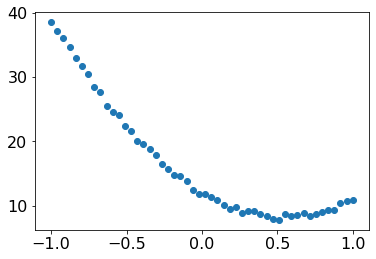

In [342]:
plt.figure()
plt.scatter(x, y)

In [343]:
lr = LinearPolynomialBasisRegression()

In [344]:
X = x.reshape(-1, 1)

In [345]:
lr.fit(X, y, method='direct', maxdegs=[2], max_deg_total=None)

In [346]:
lr.w_ml

array([ 12.01360458, -14.06144905,  12.98007647])

In [347]:
lr.loss(X, y)

2.1703577528145583

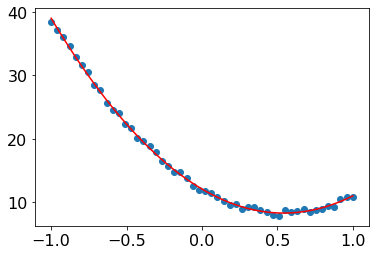

In [348]:
plt.figure()
plt.scatter(x, y)
plt.plot(X, lr.predict(X), c='r')

# 2D example

In [349]:
x = np.linspace(0,1,10)
xx, yy = np.meshgrid(x,x)
xx = xx.ravel()
yy = yy.ravel()
X = np.zeros(shape=(len(xx), 2))
X[:,0] = xx
X[:,1] = yy

y = np.sin(5 * X[:,0]) + .4 * np.sin(X[:,1])

In [350]:
Xval = np.random.random((500, 2))
yval = np.sin(5 * Xval[:,0]) + .4 * np.sin(Xval[:,1])

In [351]:
lr = LinearPolynomialBasisRegression()

In [352]:
lr.fit(X, y, method='direct', maxdegs=[6,3], max_deg_total=6)

In [353]:
lr.w_ml

array([ 6.30850684e-05,  4.90475476e+00,  1.45008941e+00, -2.83159752e+01,
        1.60714504e+01,  1.54474387e+01, -1.05169130e+01,  4.01672379e-01,
        6.39488462e-14, -7.88702437e-13,  1.62003744e-12, -1.42108547e-12,
        4.61852778e-13, -7.51133315e-03,  5.68434189e-14,  4.26325641e-13,
       -7.67386155e-13,  2.94875235e-13, -5.75785352e-02, -7.81597009e-14,
       -1.42108547e-14,  1.13686838e-13])

In [386]:
lr.degrees

[[0, 0],
 [1, 0],
 [2, 0],
 [3, 0],
 [4, 0],
 [5, 0],
 [6, 0],
 [0, 1],
 [1, 1],
 [2, 1],
 [3, 1],
 [4, 1],
 [5, 1],
 [0, 2],
 [1, 2],
 [2, 2],
 [3, 2],
 [4, 2],
 [0, 3],
 [1, 3],
 [2, 3],
 [3, 3]]

In [387]:
lr.loss(X, y)

2.4270940791283344e-05

In [388]:
lr.loss(Xval, yval)

0.00026436725414947696

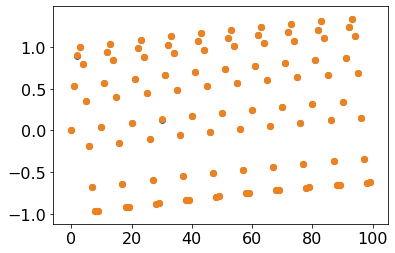

In [389]:
plt.figure()
plt.scatter(range(len(y)), y)
plt.scatter(range(len(y)), lr.predict(X))

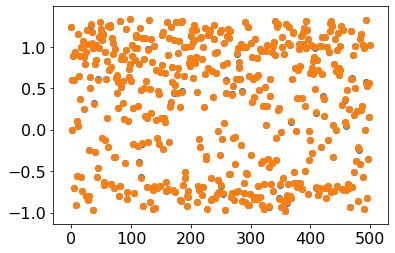

In [390]:
plt.figure()
plt.scatter(range(len(yval)), yval)
plt.scatter(range(len(yval)), lr.predict(Xval))

# 5D example

In [611]:
def gen_data(x):
    x0, x1, x2, x3, x4 = np.meshgrid(x, x, x, x, x)
    x0 = x0.ravel()
    x1 = x1.ravel()
    x2 = x2.ravel()
    x3 = x3.ravel()
    x4 = x4.ravel()
    z = np.sin(5 * x0) + .4 * np.sin(x1) + .2 * np.sin(x2) \
         + .9 * np.sin(x3) \
         + .3 * np.sin(x4)
    z += np.random.uniform(-0.1,0.1, size=len(z))
    return x0, x1, x2, x3, x4, z

In [612]:
x = np.linspace(0, 1, 4)
x0, x1, x2, x3, x4, y = gen_data(x)
X = np.column_stack((x0, x1, x2, x3, x4))

In [613]:
X.shape

(1024, 5)

In [614]:
y.shape

(1024,)

In [615]:
x = np.linspace(0, 1, 5)
x0, x1, x2, x3, x4, yval = gen_data(x)
Xval = np.column_stack((x0, x1, x2, x3, x4))

In [616]:
lr = LinearPolynomialBasisRegression()

In [617]:
lr.fit(X, y, method='direct', maxdegs=[3,3,3,3,3], max_deg_total=3)

In [618]:
lr.w_ml.shape

(56,)

In [619]:
len(lr.degrees)

56

In [620]:
lr.loss(X, y)

1.545591692546753

In [621]:
lr.loss(Xval, yval)

11.748171341145481

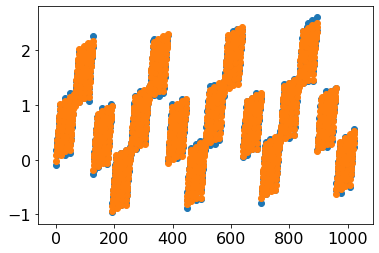

In [622]:
plt.figure()
plt.scatter(range(len(y)), y)
plt.scatter(range(len(y)), lr.predict(X))

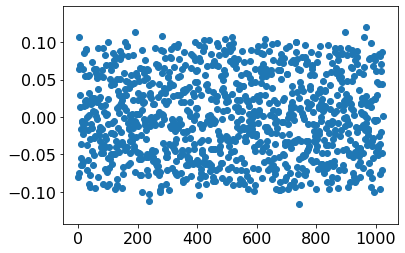

In [623]:
plt.figure()
plt.scatter(range(len(y)), y - lr.predict(X))

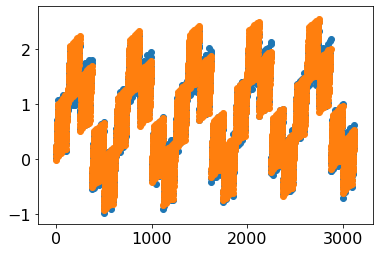

In [624]:
plt.figure()
plt.scatter(range(len(yval)), yval)
plt.scatter(range(len(yval)), lr.predict(Xval))

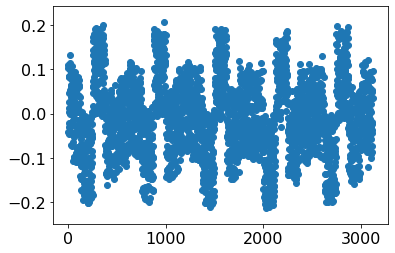

In [625]:
plt.figure()
plt.scatter(range(len(yval)), yval - lr.predict(Xval))

In [626]:
%%timeit
lr.predict(Xval[0].reshape(1,-1))

446 µs ± 9.06 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


# 7D example

In [662]:
def gen_data(x):
    x0, x1, x2, x3, x4, x5, x6 = np.meshgrid(x, x, x, x, x, x, x)
    x0 = x0.ravel()
    x1 = x1.ravel()
    x2 = x2.ravel()
    x3 = x3.ravel()
    x4 = x4.ravel()
    x5 = x5.ravel()
    x6 = x6.ravel()
    z = np.sin(5 * x0) + .4 * np.sin(x1) + .2 * np.sin(x2) \
         + .9 * np.sin(x3) \
         + .3 * np.sin(x4) \
         + .1 * np.sin(x5) \
         + np.sin(x6)
    z += np.random.uniform(-0.1,0.1, size=len(z))
    return x0, x1, x2, x3, x4, x5, x6, z

In [663]:
x = np.linspace(0, 1, 4)
x0, x1, x2, x3, x4, x5, x6, y = gen_data(x)
X = np.column_stack((x0, x1, x2, x3, x4, x5, x6))

In [664]:
X.shape

(16384, 7)

In [665]:
y.shape

(16384,)

In [666]:
x = np.linspace(0, 1, 5)
x0, x1, x2, x3, x4, x5, x6, yval = gen_data(x)
Xval = np.column_stack((x0, x1, x2, x3, x4, x5, x6))

In [667]:
Xval.shape

(78125, 7)

In [676]:
lr = LinearPolynomialBasisRegression()

In [712]:
lr.fit(X, y, method='direct', maxdegs=[3,3,3,3,3,3,3], max_deg_total=3)
# lr.fit(X, y, method='least-squres', maxdegs=[3,3,3,3,3,3,3], max_deg_total=3)
# lr.fit(X, y, method='direct', maxdegs=[2,2,2,2,2,2,2], max_deg_total=3)

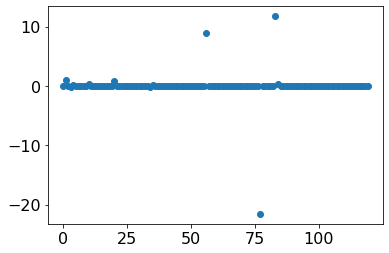

In [713]:
plt.figure()
plt.scatter(range(len(lr.w_ml)), lr.w_ml)

In [714]:
lr.w_ml.shape

(120,)

In [715]:
len(lr.degrees)

120

In [716]:
lr.loss(X, y)

26.999137642751595

In [717]:
lr.loss(Xval, yval)

293.2336590672801

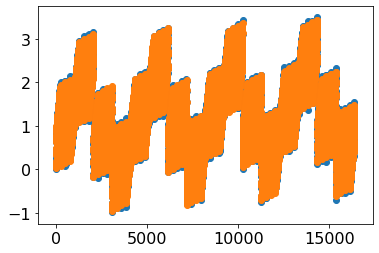

In [718]:
plt.figure()
plt.scatter(range(len(y)), y)
plt.scatter(range(len(y)), lr.predict(X))

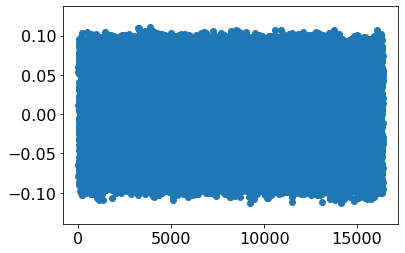

In [719]:
plt.figure()
plt.scatter(range(len(y)), y - lr.predict(X))

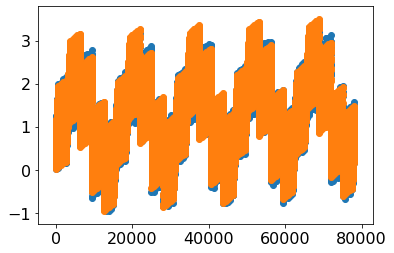

In [720]:
plt.figure()
plt.scatter(range(len(yval)), yval)
plt.scatter(range(len(yval)), lr.predict(Xval))

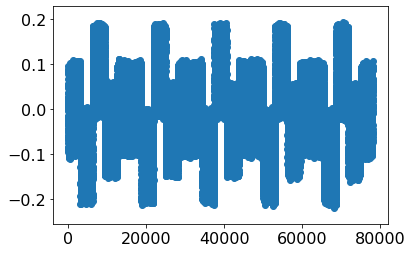

In [721]:
plt.figure()
plt.scatter(range(len(yval)), yval - lr.predict(Xval))

In [722]:
%%timeit
lr.predict(Xval[0].reshape(1,-1))

950 µs ± 9.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
